In [1]:
import numpy
import pylab as plt
import json
import torch
import torchvision
from dalle import TextTokenizer
from utils_sr import *
from PIL import Image
from tqdm import tqdm
from dalle import VQGanDetokenizer

Ft = lambda x: torch.fft.ifftshift(torch.fft.fftn(torch.fft.ifftshift(x, dim=(-1,-2)), dim=(-1,-2)), dim=(-1,-2))
IFt = lambda x: torch.fft.ifftshift(torch.fft.ifftn(x, dim=(-1,-2)), dim=(-1,-2))


detokenizer = VQGanDetokenizer().eval().cuda()
detokenizer.load_state_dict(torch.load('models/detoker.pt'))
net = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights.IMAGENET1K_V1).cuda().eval()

transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.float() / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_spectrum_power(w, h):
    x = torch.linspace(-w//2, w//2, w).view(-1, 1)
    y = torch.linspace(-h//2, h//2, h).view(-1, 1)
    return 1 / (x ** 2 + y.T ** 2).sqrt()

def get_vgg_features(x: torch.Tensor, layers: torch.nn.Module, num: int):
    outputs = []
    y = x
    total = 0
    for l in layers:
        y = l(y)
        if isinstance(l, torch.nn.ReLU):
            outputs.append(y)
            total += 1
            if num == total:
                return outputs
    return outputs

/home/airplaneless/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


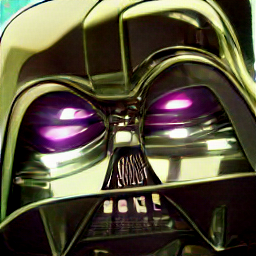

In [2]:
lr_image = Image.open('output.png').convert('RGB')
lr_image

In [3]:
lr_image = torch.from_numpy(np.array(lr_image))
lr_image.shape

torch.Size([256, 256, 3])

In [8]:
_z = torch.nn.Parameter(data=torch.randn(1, 16, 16, 2**8).cuda(), requires_grad=True)
y = lr_image.float().cuda().movedim(-1,0)[None]
spower = get_spectrum_power(256, 256).cuda()
with torch.no_grad():
    yft = get_vgg_features(y / 255., net.features, 9)
optim = torch.optim.Adam(params=[_z], lr=5e-1)
pbar = tqdm(range(200))
for _ in pbar:
    z = _z.permute(0, 3, 1, 2).contiguous().cuda()
    z = detokenizer.post_quant_conv.forward(z)
    z = detokenizer.decoder.conv_in.forward(z)
    z = detokenizer.decoder.mid.forward(z, 16, 16)
    for i in range(4, -1, -1):
        z = detokenizer.decoder.up[i].forward(z, 16, 16)
    z = detokenizer.decoder.norm_out.forward(z)
    z *= torch.sigmoid(z)
    z = detokenizer.decoder.conv_out.forward(z)
    z = z.permute(0, 2, 3, 1)
    images = (z.clip(0.0, 1.0) * 255)[0].movedim(-1,0)[None]
    xft = get_vgg_features(images / 255., net.features, 9)
    loss = 0
    for _x, _y in zip(xft, yft):
        loss += torch.nn.functional.mse_loss(_x, _y)
    loss.backward()
    optim.step()
    optim.zero_grad()

    pbar.set_description(desc=f'loss: {loss.item()}')

loss: 0.004171019420027733: 100%|██████████| 200/200 [00:52<00:00,  3.83it/s] 


In [9]:
with torch.cuda.amp.autocast(dtype=torch.float32) and torch.no_grad():
    z = _z.permute(0, 3, 1, 2).contiguous().cuda()
    z = detokenizer.post_quant_conv.forward(z)
    z = detokenizer.decoder.conv_in.forward(z)
    z = detokenizer.decoder.mid.forward(z, 16, 16)
    for i in range(4, -1, -1):
        z = detokenizer.decoder.up[i].forward(z, 16, 16)
    z = detokenizer.decoder.norm_out.forward(z)
    z *= torch.sigmoid(z)
    z = detokenizer.decoder.conv_out.forward(z)
    z = z.permute(0, 2, 3, 1)
    images = (z.clip(0.0, 1.0) * 255).cpu().detach()

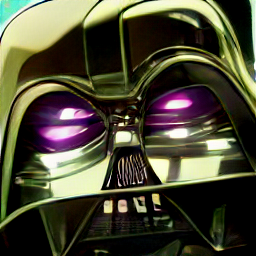

In [10]:
img = Image.fromarray((images[0].numpy()).astype(numpy.uint8))
img

In [23]:
with torch.cuda.amp.autocast(dtype=torch.float32) and torch.no_grad():
    image_tokens = (
        detokenizer.embedding.weight[:, :, None].cpu() -
        _z.reshape(256, 256).T.cpu()
    ).norm(p=2, dim=-2).argmin(0)

In [24]:
with torch.cuda.amp.autocast(dtype=torch.float32) and torch.no_grad():
    z = image_tokens.reshape(-1, 256).cuda()
    z.clamp_(0, detokenizer.vocab_count - 1)
    # z = z.view([1, 1, 2 ** 4, 2 ** 4])
    z = detokenizer.embedding.forward(z)
    z = z.view((1, 16, -1, 2 ** 8))
    t1 = z.shape[1]; t2 = z.shape[2]
    z = z.permute(0, 3, 1, 2).contiguous()
    z = detokenizer.post_quant_conv.forward(z)
    z = detokenizer.decoder.conv_in.forward(z)
    z = detokenizer.decoder.mid.forward(z, t1, t2)
    for i in range(4, -1, -1):
        z = detokenizer.decoder.up[i].forward(z, t1, t2)
    z = detokenizer.decoder.norm_out.forward(z)
    z *= torch.sigmoid(z)
    z = detokenizer.decoder.conv_out.forward(z)
    z = z.permute(0, 2, 3, 1)
    images = (z.clip(0.0, 1.0) * 255).cpu().detach()

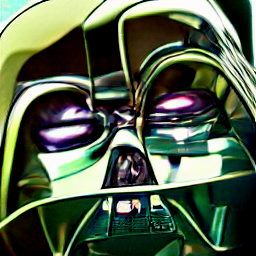

In [25]:
img = Image.fromarray((images[0].numpy()).astype(numpy.uint8))
img